# Phase 2: Fuzzy Feature Engineering and Decision Tree Optimization

This notebook demonstrates fuzzy feature engineering and decision tree optimization using hill-climbing and grid search on the breast cancer dataset.

## 1. Import Required Libraries

We import libraries for data manipulation, visualization, and machine learning.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.datasets import load_breast_cancer

## 2. Load and Split the Dataset

Load the breast cancer dataset and split it into training and test sets.

### About the Breast Cancer Dataset

The breast cancer dataset used in this notebook is the Wisconsin Diagnostic Breast Cancer (WDBC) dataset, available from scikit-learn. It contains features computed from digitized images of fine needle aspirate (FNA) of breast masses. Each sample describes characteristics of the cell nuclei present in the image, such as radius, texture, perimeter, area, smoothness, and more.

- **Samples:** 569
- **Features:** 30 numeric features per sample
- **Target:** Binary classification (malignant or benign)
- **Source:** UCI Machine Learning Repository

This dataset is commonly used for benchmarking classification algorithms in medical diagnosis tasks.

In [6]:
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

## 3. Data Cleaning

Check for missing values and duplicates in the training data, and handle them if present.

In [7]:
if X_train.isnull().sum().sum() > 0:
    X_train = X_train.fillna(X_train.mean())
    X_test = X_test.fillna(X_train.mean())

X_train = X_train.drop_duplicates()

## 4. Visualize Feature Distributions

Plot histograms for the first four features to understand their distributions.

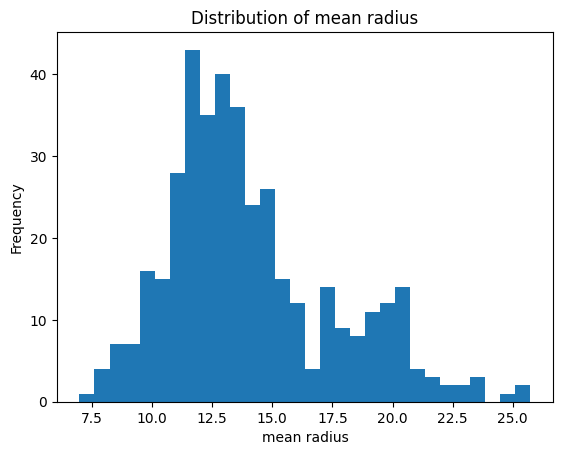

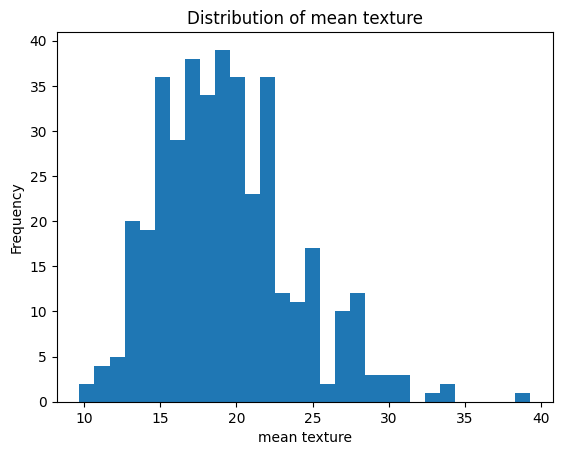

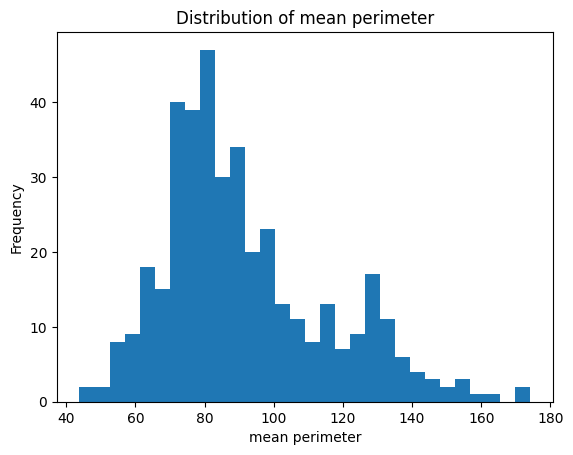

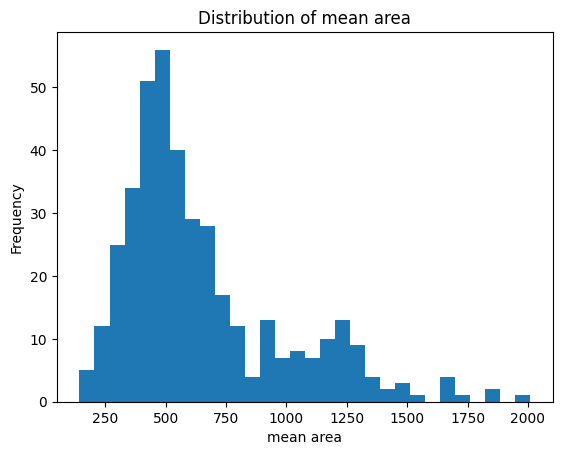

In [8]:
features_to_plot = X_train.columns[:4]
for feat in features_to_plot:
    plt.figure()
    plt.hist(X_train[feat], bins=30)
    plt.title(f"Distribution of {feat}")
    plt.xlabel(feat)
    plt.ylabel('Frequency')
    plt.show()

## 5. Feature Scaling

Apply Min-Max scaling to the features to normalize them between 0 and 1.

In [9]:
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)


## 6. Fuzzy Feature Engineering

Create fuzzy features for the first three features using triangular membership functions for 'low', 'medium', and 'high' values.

In [10]:
fuzzy_feats = X_train_scaled.columns[:3]

# Define triangular membership functions
def triangular(x, a, b, c):
    return np.maximum(np.minimum((x-a)/(b-a), (c-x)/(c-b)), 0)

# Compute membership degrees for 'low','medium','high'
fuzzy_train = pd.DataFrame(index=X_train_scaled.index)
fuzzy_test = pd.DataFrame(index=X_test_scaled.index)

for feat in fuzzy_feats:
    vals = X_train_scaled[feat]
    a, b, c = vals.min(), vals.median(), vals.max()
    fuzzy_train[f"{feat}_low"] = triangular(vals, a, a, b)
    fuzzy_train[f"{feat}_med"] = triangular(vals, a, b, c)
    fuzzy_train[f"{feat}_high"] = triangular(vals, b, c, c)

    # apply same parameters to test
    vals_t = X_test_scaled[feat]
    fuzzy_test[f"{feat}_low"] = triangular(vals_t, a, a, b)
    fuzzy_test[f"{feat}_med"] = triangular(vals_t, a, b, c)
    fuzzy_test[f"{feat}_high"] = triangular(vals_t, b, c, c)

# Append fuzzy features
X_train_fuzzy = pd.concat([X_train_scaled, fuzzy_train], axis=1)
X_test_fuzzy = pd.concat([X_test_scaled, fuzzy_test], axis=1)


## 7. Hill-Climbing Search for Decision Tree Depth

Split the training set into a sub-training and validation set, then use hill-climbing to find the optimal tree depth.

In [18]:
X_sub, X_val, y_sub, y_val = train_test_split(
    X_train_fuzzy, y_train, test_size=0.2, random_state=1, stratify=y_train
)
def evaluate_depth(depth):
    clf = DecisionTreeClassifier(max_depth=depth, random_state=0)
    clf.fit(X_sub, y_sub)
    return clf.score(X_val, y_val)

# Hill-climbing search for max_depth
current_depth = 3
current_score = evaluate_depth(current_depth)
path = [(current_depth, current_score)]
improved = True
while improved:
    improved = False
    neighbors = [d for d in [current_depth-1, current_depth+1] if d >= 1]
    scores = [(d, evaluate_depth(d)) for d in neighbors]
    best_d, best_s = max(scores, key=lambda x: x[1])
    if best_s > current_score:
        current_depth, current_score = best_d, best_s
        path.append((current_depth, current_score))
        improved = True

print("Hill-Climbing path:", path)

# Final model from hill-climbing
best_depth = current_depth
clf_hc = DecisionTreeClassifier(max_depth=best_depth, random_state=0)
clf_hc.fit(X_train_fuzzy, y_train)


Hill-Climbing path: [(3, 0.9), (2, 0.9125)]


DecisionTreeClassifier(max_depth=2, random_state=0)

## 8. Brute-Force Grid Search for Comparison

Compare the hill-climbing result to a brute-force grid search over possible tree depths.

In [19]:
# 7. Compare to Brute-Force Grid Search
grid_results = []
for d in range(1, 11):
    s = evaluate_depth(d)
    grid_results.append((d, s))

print("Grid search results:", grid_results)


Grid search results: [(1, 0.8875), (2, 0.9125), (3, 0.9), (4, 0.9125), (5, 0.925), (6, 0.9125), (7, 0.9125), (8, 0.9125), (9, 0.9125), (10, 0.9125)]


## 9. Visualize the Final Decision Tree

Plot the final decision tree obtained from the hill-climbing search.

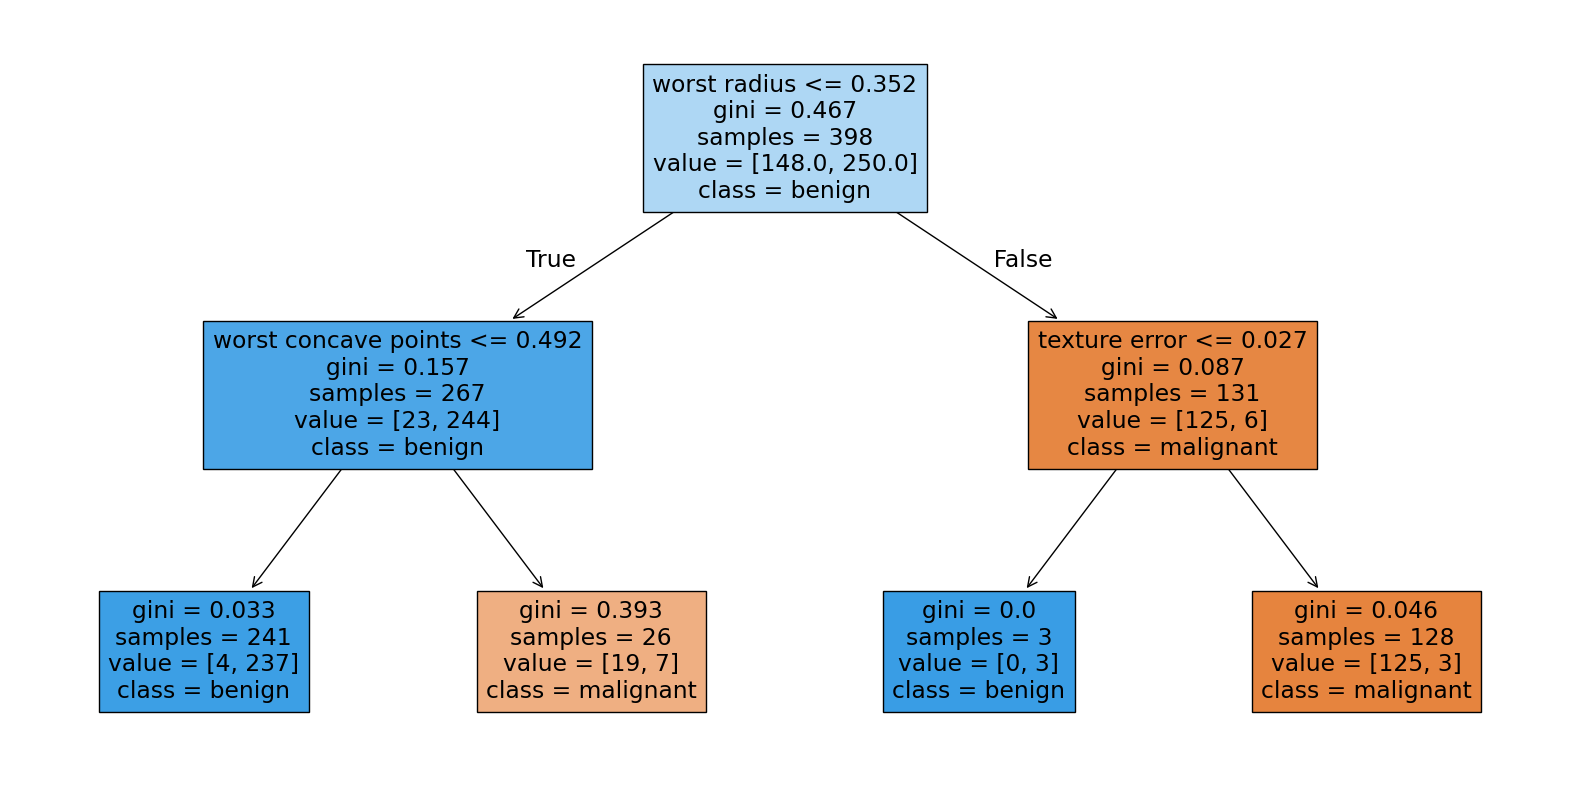

In [20]:
# 8. Visualize the Final Tree
plt.figure(figsize=(20,10))
plot_tree(clf_hc, feature_names=X_train_fuzzy.columns, class_names=data.target_names, filled=True)
plt.show()


## 10. Evaluate the Model on the Test Set

Evaluate the final model on the test set and display accuracy, classification report, and confusion matrix.

In [21]:
# 9. Evaluate on Test Set
y_pred = clf_hc.predict(X_test_fuzzy)

acc = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
cm = confusion_matrix(y_test, y_pred)

print(f"Test Accuracy: {acc:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=data.target_names))
print("Confusion Matrix:\n", cm)


Test Accuracy: 0.9181
Classification Report:
              precision    recall  f1-score   support

   malignant       0.89      0.89      0.89        64
      benign       0.93      0.93      0.93       107

    accuracy                           0.92       171
   macro avg       0.91      0.91      0.91       171
weighted avg       0.92      0.92      0.92       171

Confusion Matrix:
 [[ 57   7]
 [  7 100]]
